In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random 
import numpy as np
import math
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
str_to_inx = {str:inx for inx, str in enumerate(chars, start=1)}
str_to_inx['.'] = 0
inx_to_str = {str:inx for inx, str in str_to_inx.items()}
vocab_size = len(inx_to_str)
inx_to_str

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
# build the dataset
random.shuffle(words)
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for word in words:
    word = block_size * '.' + word + '.'
    end_inx = block_size
    for start_inx, char in enumerate(word[block_size:]):
        X.append([str_to_inx[ch] for ch in word[start_inx:end_inx]])
        Y.append(str_to_inx[char])
        end_inx += 1


X, Y = torch.tensor(X), torch.tensor(Y)
X

tensor([[ 0,  0,  0],
        [ 0,  0,  3],
        [ 0,  3,  1],
        ...,
        [ 1, 18, 18],
        [18, 18,  1],
        [18,  1,  8]])

In [5]:
# data set splits
train_range = math.ceil(len(X) * 0.8)
dev_range = (len(X) - train_range) // 2

training_set = X[:train_range]
dev_set = X[train_range:train_range+dev_range]
test_set = X[train_range+dev_range:]

y_training_set = Y[:train_range]
y_dev_set = Y[train_range:train_range+dev_range]
y_test_set = Y[train_range+dev_range:]

assert training_set.nelement() + dev_set.nelement() + test_set.nelement() == X.nelement(), "Bad split"

Why *0.01, etc.? Weights are too diverse (i.e very wrong) at the initialization and it unnecessarily increases the loss at the beginning of the training. When they are too diverse tanh produces values very close to -1 or 1 which is bad for the gradient flow (see micrograd tanh implementation; gradient doesn't flow because it's in the flattened region)

In [44]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [53]:
# train
inxs = []
losses = []
batch_size = 32
steps = 100000
for i in range(steps):
    # minibatch construct
    inx = torch.randint(0, training_set.shape[0], (batch_size,), generator=g)

    # forward pass
    emb = C[training_set[inx]] # grab only those rows from the minibatch 
    h_preact = emb.view(-1, block_size*n_embd) @ W1 + b1
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_training_set[inx]) + 0.01*(W2**2).mean()
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    l_r = 0.01
    for p in parameters:
        p.data += -l_r * p.grad

    #stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{steps:7d}: {loss.item():.4f}')
    losses.append(loss.item())
    inxs.append(i)
loss.item() # best loss 2.14

      0/ 100000: 2.0768
   1000/ 100000: 2.2006
   2000/ 100000: 2.2361
   3000/ 100000: 2.5647
   4000/ 100000: 1.8772
   5000/ 100000: 2.1576
   6000/ 100000: 2.3506
   7000/ 100000: 2.3904
   8000/ 100000: 2.2920
   9000/ 100000: 1.9919
  10000/ 100000: 1.9360
  11000/ 100000: 2.0415
  12000/ 100000: 1.7497
  13000/ 100000: 2.1140
  14000/ 100000: 1.7926
  15000/ 100000: 2.1066
  16000/ 100000: 2.4009
  17000/ 100000: 2.6332
  18000/ 100000: 2.2955
  19000/ 100000: 2.5328
  20000/ 100000: 1.9735
  21000/ 100000: 2.2375
  22000/ 100000: 2.2449
  23000/ 100000: 2.2736
  24000/ 100000: 2.0960
  25000/ 100000: 1.8999
  26000/ 100000: 2.0845
  27000/ 100000: 2.3020
  28000/ 100000: 2.1530
  29000/ 100000: 1.5323
  30000/ 100000: 1.9211
  31000/ 100000: 2.3818
  32000/ 100000: 2.2806
  33000/ 100000: 1.9206
  34000/ 100000: 2.2128
  35000/ 100000: 2.2183
  36000/ 100000: 2.2118
  37000/ 100000: 2.4975
  38000/ 100000: 1.9714
  39000/ 100000: 1.7957
  40000/ 100000: 2.0809
  41000/ 100000:

1.9777179956436157

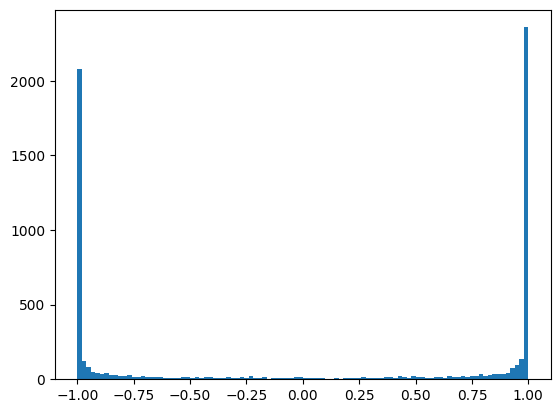

In [49]:
plt.hist(h.view(-1).tolist(), 100);

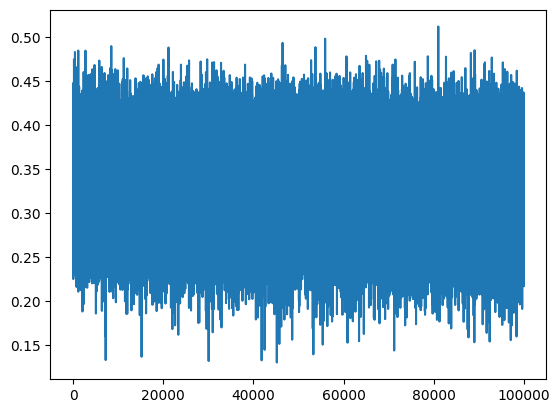

In [52]:
plt.plot(inxs, np.log10(losses))
# plt.xscale("log")

In [54]:
@torch.no_grad() # disable gradient tracking
def get_loss(data_set):
    x, y = {
        'train': (training_set, y_training_set),
        'dev': (dev_set, y_dev_set),
        'test': (test_set, y_test_set)
    }[data_set]

    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # (x, hidden)
    logits = h @ W2 + b2 # (hidden, vocab_size )
    loss = F.cross_entropy(logits, y)
    print(data_set, loss.item())

get_loss('train')
get_loss('dev')

train 2.121603488922119
dev 2.169416904449463


In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
	out = '.' * block_size
	while True:
		emb = C[torch.tensor([str_to_inx[x] for x in out[-block_size:]])] # (1,block_size,d)
		h = torch.tanh(emb.view(1, -1) @ W1 + b1)
		logits = h @ W2 + b2
		probs = F.softmax(logits, dim=1)
		inx = torch.multinomial(probs, num_samples=1, generator=g).item()
		out = out + inx_to_str[inx]
		if inx == 0:
			break
    
	print(out.replace('.', ''))

carpahxaal
hlrif
jmrix
thty
skansskeja
hnen
dmeryhc
kaqhi
nelania
chriiv
kanein
dhlm
join
qhinn
sroilea
jadbi
wanelogiearixi
jkaei
iusa
med
